In [ ]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



import tensorflow_datasets as tfds

In [ ]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteE0BIDY/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteE0BIDY/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteE0BIDY/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Print information about the data

print(p_camelyon_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [ ]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [ ]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(32)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


Step 2: Different activation functions

In [ ]:
from tensorflow.keras.layers import MaxPool2D

# Building the Convolutonal Neural Network Model 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Rely activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

#Optimiser = adam
model1 = Model(inputs=input, outputs = output)
model1.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        1849

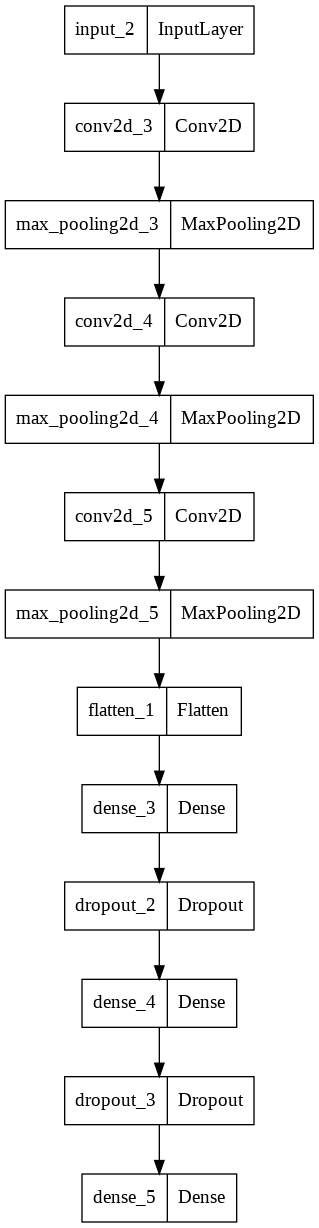

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model1)

In [ ]:
import math

batch_size_for_training = 32
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  8192
Validation steps:  256
Testing steps:  256


In [ ]:
# Training the model
# steps_per_epoch = (number_of_train_sample/batch_size)

history1= model1.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
8192/8192 [==============================] - 99s 12ms/step - loss: 0.3879 - acc: 0.8295 - val_loss: 0.3447 - val_acc: 0.8438
Epoch 2/10
8192/8192 [==============================] - 101s 12ms/step - loss: 0.2816 - acc: 0.8861 - val_loss: 0.3857 - val_acc: 0.8327
Epoch 3/10
8192/8192 [==============================] - 96s 12ms/step - loss: 0.2399 - acc: 0.9056 - val_loss: 0.3986 - val_acc: 0.8366
Epoch 4/10
8192/8192 [==============================] - 94s 11ms/step - loss: 0.2118 - acc: 0.9173 - val_loss: 0.4141 - val_acc: 0.8387
Epoch 5/10
8192/8192 [==============================] - 114s 14ms/step - loss: 0.1895 - acc: 0.9275 - val_loss: 0.4236 - val_acc: 0.8438
Epoch 6/10
8192/8192 [==============================] - 117s 14ms/step - loss: 0.1713 - acc: 0.9354 - val_loss: 0.5493 - val_acc: 0.8250
Epoch 7/10
8192/8192 [==============================] - 96s 12ms/step - loss: 0.1534 - acc: 0.9431 - val_loss: 0.4617 - val_acc: 0.8387
Epoch 8/10
8192/8192 [=======================

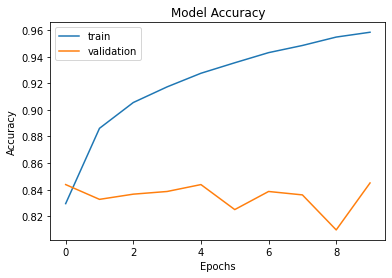

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

plot_hist(history1)

In [ ]:
# Testing the model

prediction = model1.predict(test_images)
pred = tf.argmax(prediction, axis=1)
true_label = tf.concat([y for x, y in test_images], axis=0)
#evaluation = model.evaluate(test_images, test_labels, verbose=1)
#print("Test dataset accuracy is: {0:.4f}".format(model.evaluate(test_ds, steps=steps, verbose=1)[1]))

ValueError: ignored

In [ ]:
confusion_matrix = metrics.ConfusionMatrixDisplay.from_predictions(true_label, pred)
plt.show(confusion_matrix)

In [ ]:
# Building the Convolutonal Neural Network Model 2

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
model2 = Model(inputs=input, outputs = output)
model2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model2.summary()

In [ ]:
# Building the Convolutonal Neural Network Model 3

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
model3 = Model(inputs=input, outputs = output)
model3.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model3.summary()
plot_model(model3)